In [1]:
%reload_ext autoreload
%autoreload 2
import sys  
sys.path.insert(1, 'functions/')
from statistics_functions import *
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import cartopy.crs as ccrs
import cartopy

In [2]:
base_path  = '/work/bk1377/a270230/'
path_ds    = base_path + 'lkf_datasets/daily_data/'
path_ice   = base_path + 'interpolated_fesom_output/'
path_out   = base_path + 'data_transfer/'

# check that both the dataset and the nc file exist
files = os.listdir(path_ice)
files.sort()
files.remove('.ipynb_checkpoints')
#files.remove('fesom_ifs')
#files

# Load the Detected and Tracked LKFs

In [3]:
years = [2013, 2016, 2020, 2093, 2096, 2099]

In [4]:
%%time
# calculate the total ice area (in km2) at every time step
ice_coverage, ice_coverage_weekly = get_ice_coverage(years, path_ice)

# get the lkf_data objects
datasets = []
for year in years:
    datasets += np.load(path_ds + f'ds_{year}.npy', allow_pickle=True)[0],

# get the lkf data as array for every timestep
lkfs = []
for lkf_data in datasets:
    lkfs += get_lkfs(lkf_data)[:365],

# get the tracks for every timestep
tracks = []
for lkf_data in datasets:
    tracks += get_tracks(lkf_data),

# get the lkf paths starting at each timestep as well as
# the paths going through the timesteps
paths, paths_all = [], []
for lkfs_dataset, tracks_dataset in zip(lkfs, tracks):
    a, b       = get_lkf_paths(lkfs_dataset, tracks_dataset)
    paths     += a,
    paths_all += b,

CPU times: user 36.7 s, sys: 8.34 s, total: 45 s
Wall time: 3min 3s


In [5]:
# show the first matching pairs at each day
#tracks_all_dataset = tracks[0]
#print('\n'.join(['   \t'.join([str(tracks_all_dataset[day][lkf]).replace('[ ','[').replace('[ ','[') for day in range(7)]) for lkf in range(10)]))

In [6]:
np.save(path_out + 'data_lkfs_paths.npy', np.array([years, ice_coverage, lkfs, paths, paths_all], dtype='object'), allow_pickle=True)

In [7]:
[years, ice_coverage, lkfs, paths, paths_all] = np.load(path_out + 'data_lkfs_paths.npy', allow_pickle=True)

# Calculate Metrics

In [8]:
# get the number of lkfs at each timestep
n_lkfs = []
for lkfs_all_dataset in lkfs:
    n_lkfs.append(get_n_lkfs(lkfs_all_dataset))

# get the number of lkfs per ice covered area at every timestep,
# the scaling is 1/ (100km * 100km)
rho_lkfs = [[] for _ in years]
for year in range(len(years)):
    rho_lkfs[year] = np.array(n_lkfs[year]) / np.array(ice_coverage[year]) * 10000

# get the length of every LKF as well as the average
# LKF length in pixels at every timestep
lkf_len, av_lkf_len, total_lkf_len = [], [], []
for lkfs_all_dataset in lkfs:
    a, b, c = get_lkf_len(lkfs_all_dataset)
    lkf_len.append(a)
    av_lkf_len.append(b)
    total_lkf_len.append(c)

# get the lifetime of the lkf paths and their mean as well as
# the mean of only the paths that are longer than one day
lifetimes, mean_lifetime, mean_lifetime_tracked_lkfs = [], [], []
for lkf_paths_dataset in paths:
    a, b, c = get_lifetimes(lkf_paths_dataset)
    lifetimes.append(a)
    mean_lifetime.append(b)
    mean_lifetime_tracked_lkfs.append(c)
    
# this includes the lifetimes of LKFs that are already counted in
# previous timesteps. from this, do not use the mean lifetime!
lifetimes_all = []
for lkf_paths_dataset in paths_all:
    a, _, _ = get_lifetimes(lkf_paths_dataset)
    lifetimes_all.append(a)

/tmp/ipykernel_274793/3190285686.py:10: RuntimeWarning: invalid value encountered in divide
  rho_lkfs[year] = np.array(n_lkfs[year]) / np.array(ice_coverage[year]) * 10000
/home/a/a270230/LKF/lkf_detection/functions/statistics_functions.py:64: RuntimeWarning: Mean of empty slice
  av_lkf_len.append(np.nanmean(lkf_len[timestep]))
/home/a/a270230/LKF/lkf_detection/functions/statistics_functions.py:181: RuntimeWarning: Mean of empty slice.
  mean_lifetime.append(lifetimes_timestep.mean())
/home/a/a270230/miniconda3/envs/lkf_tools/lib/python3.11/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount
/home/a/a270230/LKF/lkf_detection/functions/statistics_functions.py:193: RuntimeWarning: Mean of empty slice.
  mean_lifetime_tracked_lkfs.append(lifetimes_tracked_lkfs_timestep.mean())


# Average Over Decades

In [9]:
def av_sd(data,i=3):
    
    av = np.mean(data[:i], axis=0)
    sd = np.sqrt(np.var(data[:i], axis=0))
    
    av_90 = np.mean(data[i:], axis=0)
    sd_90 = np.sqrt(np.var(data[i:], axis=0))

    return av, sd, av_90, sd_90

In [10]:
n_lkfs_av, n_lkfs_sd, n_lkfs_90_av, n_lkfs_90_sd = av_sd(n_lkfs)
rho_lkfs_av, rho_lkfs_sd, rho_lkfs_90_av, rho_lkfs_90_sd = av_sd(rho_lkfs)

mean_lkf_len_av, mean_lkf_len_sd, mean_lkf_len_90_av, mean_lkf_len_90_sd = av_sd(av_lkf_len)
total_lkf_len_av, total_lkf_len_sd, total_lkf_len_90_av, total_lkf_len_90_sd = av_sd(total_lkf_len)

mean_lkf_lt_av, mean_lkf_lt_sd, mean_lkf_lt_90_av, mean_lkf_lt_90_sd = av_sd(mean_lifetime)

# Create LKF Dictionary

In [11]:
LKFs = dict()

for decade, i in zip(['2010s', '2090s'], [[0,1], [2,3]]):

    df = pd.DataFrame(av_sd(n_lkfs)[i[0]], columns=['number'])
    df['number sd']        = av_sd(n_lkfs)[i[1]]
    df['density']          = av_sd(rho_lkfs)[i[0]]
    df['density sd']       = av_sd(rho_lkfs)[i[1]]
    df['mean length']      = av_sd(av_lkf_len)[i[0]]
    df['mean length sd']   = av_sd(av_lkf_len)[i[1]]
    df['total length']     = av_sd(total_lkf_len)[i[0]]
    df['total length sd']  = av_sd(total_lkf_len)[i[1]]
    df['mean lifetime']    = av_sd(mean_lifetime)[i[0]]
    df['mean lifetime sd'] = av_sd(mean_lifetime)[i[1]]

    LKFs[decade] = df

for y in range(len(years)):
    df_y = pd.DataFrame(n_lkfs[y], columns=['number'])
    df_y['density']       = rho_lkfs[y]
    df_y['mean length']   = av_lkf_len[y]
    df_y['total length']  = total_lkf_len[y]
    df_y['mean lifetime'] = mean_lifetime[y]
    
    LKFs[f'y{years[y]}'] = dict(
        total = df_y,
    )
    
    for d in range(365):
        df_d = pd.DataFrame(lkf_len[y][d], columns=['length'])
        df_d['lifetime'] = lifetimes_all[y][d]
        
        LKFs[f'y{years[y]}'][f'd{d}'] = df_d

In [12]:
np.save(path_out + 'LKFs', [LKFs])

# Load LKF Dictionary

In [13]:
LKFs = np.load(path_out + 'LKFs.npy', allow_pickle=True)[0]

In [14]:
years = []
for key in LKFs.keys():
    years += key,
    
years = years[2:]

for i, year in enumerate(years):
    years[i] = int(year[1:])

# Plot one individual year

In [15]:
years

[2013, 2016, 2020, 2093, 2096, 2099]

In [16]:
year = 2013

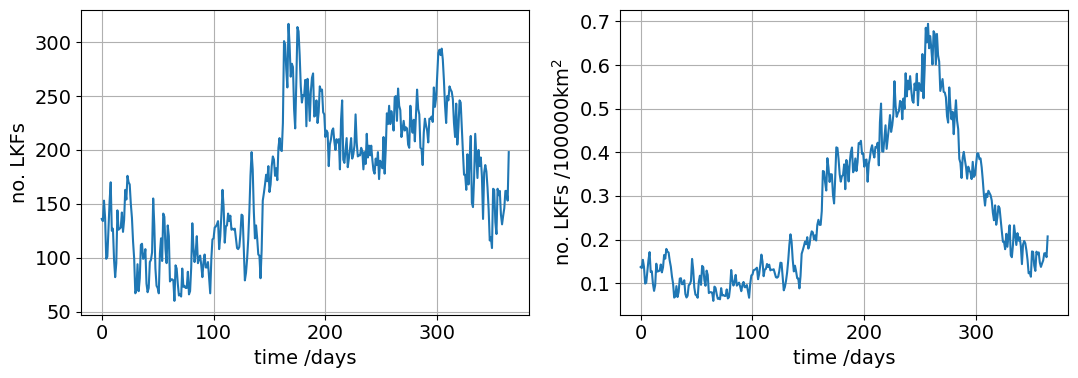

In [17]:
fig, axs = plt.subplots(1,2, figsize=(11,4))

for ax, data, ylabel in zip(
    axs, [LKFs[f'y{year}']['total'].number, LKFs[f'y{year}']['total'].density], ['no. LKFs', 'no. LKFs /100000km$^2$']
):
    
    ax.plot(data)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('time /days')
    ax.grid()

fig.tight_layout()

# Compare individual years

In [18]:
years

[2013, 2016, 2020, 2093, 2096, 2099]

In [19]:
year1 = 2013
year2 = 2093

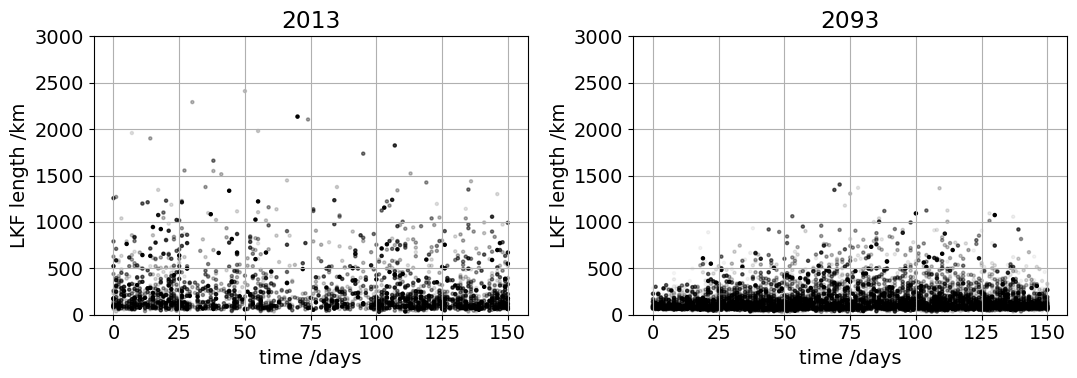

In [20]:
var = 'length'
ylabel = 'LKF length /km'
r = 151

fig, axs = plt.subplots(1,2,figsize=(11,4))

for ax, year in zip(axs, [year1, year2]):

    for d in range(r):
        values = LKFs[f'y{year}'][f'd{d}'][var]

        bins = 10
        val = np.histogram(values, bins=bins)[1]
        val = [0.5*(val[i]+val[i+1]) for i in range(len(val)-1)]
        f = np.histogram(values, bins=bins)[0]
        if np.max(f)>0:
            f = f/np.max(f)


        frequency = np.zeros(int(np.max(values)+1))
        for value in values:
            frequency[value] += 1

        f_norm = 0
        if frequency.max()>0:
            f_norm = frequency/frequency.max()
                

        ax.scatter(d * np.ones_like(values), values, s=5, c='k', alpha=f_norm)

    ax.grid()
    ax.set_ylim([0,3000])
    ax.set_ylabel(ylabel)
    ax.set_xlabel('time /days')
    ax.set_title(year)
fig.tight_layout()

# Compare 2010s with 2090s

In [21]:
def compare(var, ylabel, ylim):
    j = 151

    fig, axs = plt.subplots(1,2, figsize=(11,4))

    for ax, data, var, title in zip(
        axs, [LKFs['2010s'][var][:j], LKFs['2090s'][var][:j]], [LKFs['2010s'][var+' sd'][:j], LKFs['2090s'][var+' sd'][:j]], ['2013 - 2020', '2093 - 2100']
    ):

        ax.plot(data)
        ax.fill_between(np.arange(j), data+var, data-var, alpha=0.5)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('time /days')
        ax.set_ylim([0,ylim])
        ax.set_title(title)
        ax.grid()

    fig.tight_layout()

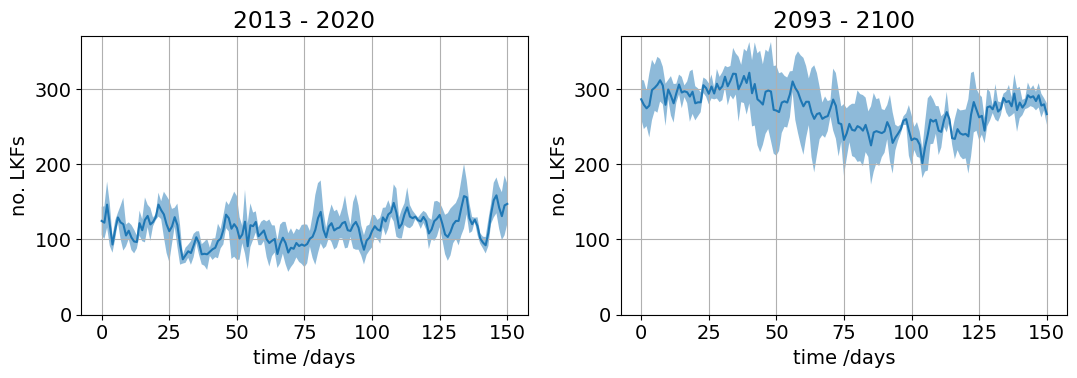

In [22]:
compare('number', 'no. LKFs', 370)

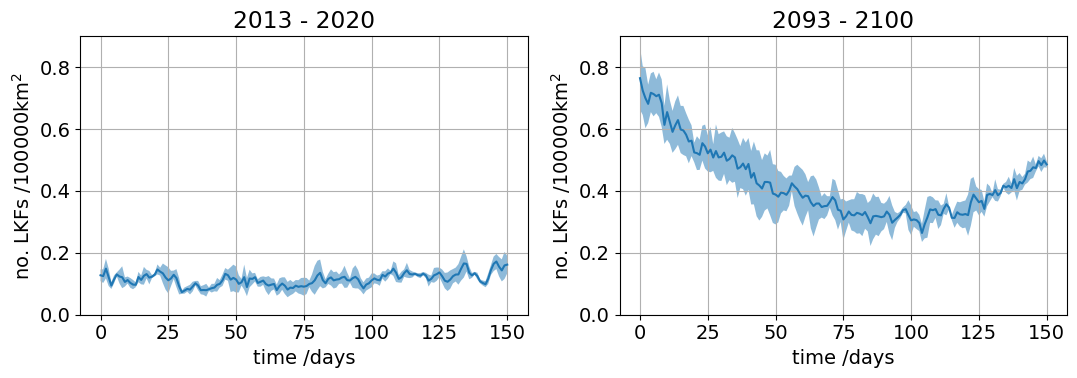

In [23]:
compare('density', 'no. LKFs /100000km$^2$', 0.9)

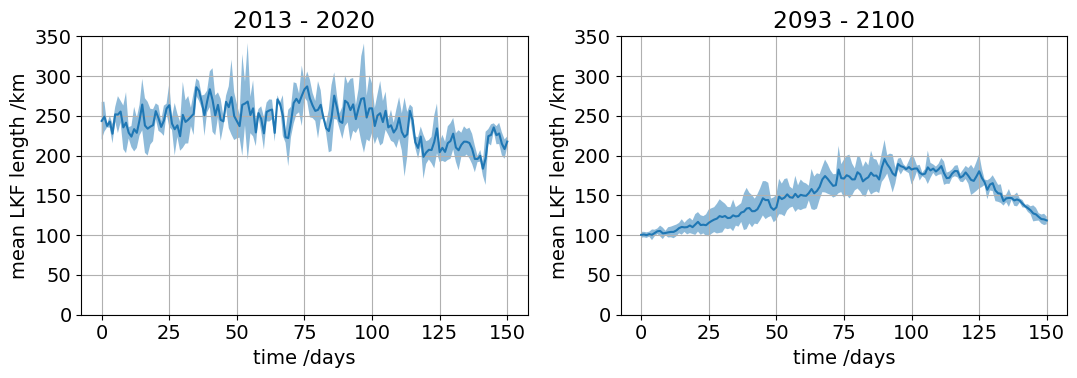

In [24]:
compare('mean length', 'mean LKF length /km', 350)

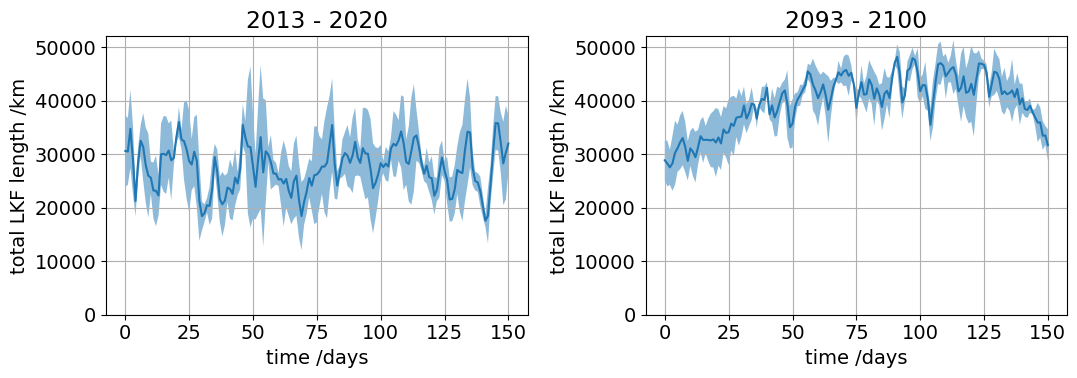

In [25]:
compare('total length', 'total LKF length /km', 52000)

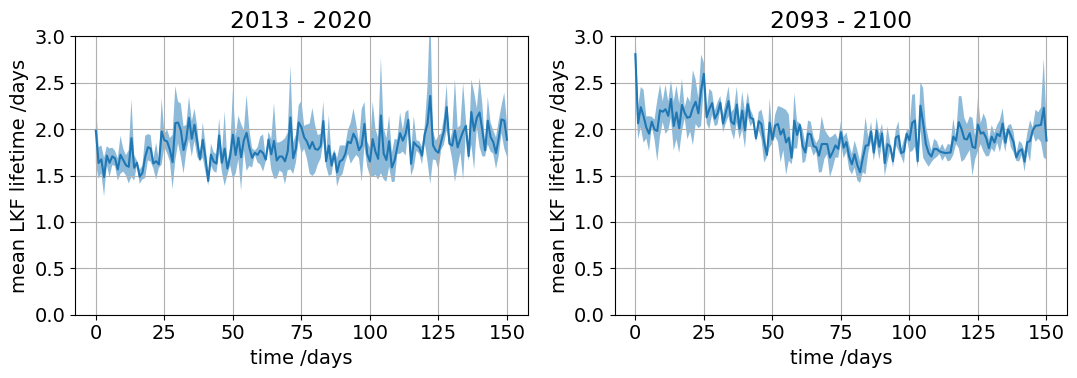

In [26]:
compare('mean lifetime', 'mean LKF lifetime /days', 3)

# 